In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
sharks= pd.read_csv("../GSAF5.csv", engine= "python")
sharks.head(50)


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,...,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,...,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,...,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,...,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.15.R,2016.09.15.R,5988,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,...,3' to 4' shark,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.11,2016.09.11,5987,NaN,NaN
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,...,"Tiger shark, 10?","Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.07,2016.09.07,5986,NaN,NaN
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,...,NaN,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.06,2016.09.06,5985,NaN,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,...,NaN,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.05.b,2016.09.05.b,5984,NaN,NaN


In [2]:
#Comenzamos con el data wrangling. En primer lugar, quiero ver todas las columnas de la base de datos ya que algunas no aparecen en el display.
sharks.columns
#Dimensión de la tabla
sharks.shape
#Cantidad de valores nulos en cada columna
sharks.isnull().sum()


Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64

In [3]:
#Borramos dos columnas que no contienen datos (1 y 2 sobre 5992) y no se sabe a qué se refieren (Unnamed 1 y Unnamed 2).
sharks.drop(['Unnamed: 22','Unnamed: 23'], axis= 1, inplace= True)


In [4]:
#Comprobar duplicated rows en las columnas indicadas
#shark_attacks[['Case Number','Case Number.1','Case Number.2']]

sharks.drop(['Case Number.1','Case Number.2'], axis= 1, inplace= True)
display(sharks)





,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,original order
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5993
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5992
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5991
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5990
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5989
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Western Australia,Bunbury,Fishing,Occupant: Ben Stratton,NaN,NaN,Shark rammed boat. No injury to occupant,N,NaN,NaN,"West Australian, 9/15/2016",2016.09.15.R-boat.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5988
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Florida,"Ponte Vedra, St. Johns County",Wading,male,M,60s,Minor injury to arm,N,15h15,3' to 4' shark,"News4Jax, 9/11/2016",2016.09.11-PonteVedra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5987
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Hawaii,"Makaha, Oahu",Swimming,female,F,51,Severe lacerations to shoulder & forearm,N,14h30,"Tiger shark, 10?","Hawaii News Now, 9/7/2016",2016.09.07-Oahu.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5986
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,North Province,Koumac,Kite surfing,David Jewell,M,50,FATAL,Y,15h40,NaN,"TVANouvelles, 9/6/2016",2016.09.06-Jewell.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5985
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,South Carolina,"Kingston Plantation, Myrtle Beach, Horry County",Boogie boarding,Rylie Williams,F,12,Lacerations & punctures to lower right leg,N,Late afternoon,NaN,"C. Creswell, GSAF",2016.09.05.b-Williams.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,5984


In [5]:
#Rename sex and species columns 
sharks.rename(index= str, columns= {'Sex ':'Sex','Species ':'Species','Fatal (Y/N)':'Fatal'}, inplace= True)




In [6]:
#Some random calculations
#Relation between fatal attacks and shark species
sharks['Species'].loc[(sharks['Fatal']=='Y')]
#Relation between types attacks and shark species
sharks['Type'].loc[(sharks['Fatal']=='Y')]

#Most deadly attacks by country, species and species in countries
sharks['Species'].loc[(sharks['Country']=='USA')]

sharks['Country'].loc[(sharks['Fatal']=='Y')]
sharks['Species'].loc[(sharks['Fatal']=='Y')]




8                                                     NaN
52                                             3+ m shark
56                                            White shark
72                                     Tiger shark, 2.5 m
83                                                    NaN
108                                                   NaN
125                                                   NaN
164                                           White shark
204                                     Bull shark, 3.5 m
208                                                   NaN
214                                            Bull shark
217                        Shark involvement not cofirmed
219                                            Mako shark
226                                    Tiger shark, 3.5 m
227                                      3.5 to 4 m shark
242                                 White shark, 4 to 5 m
248                                                   NaN
251           

In [7]:
#MOMENT OF TRUTH: TAKE DECISIONS!
#new dataframe with relevant columns that i'm going to use for my research
new_sharks = pd.DataFrame()
new_sharks['Case Number'] = sharks['Case Number']
new_sharks['Date'] = sharks['Date']
new_sharks['Year'] = sharks['Year']
new_sharks['Type'] = sharks['Type']
new_sharks['Country'] = sharks['Country']
new_sharks['Activity'] = sharks['Activity']
new_sharks['Injury'] = sharks['Injury']
new_sharks['Fatal'] = sharks['Fatal']
new_sharks['Time'] = sharks['Time']
new_sharks['Species'] = sharks['Species']
display (new_sharks)



,Case Number,Date,Year,Type,Country,Activity,Injury,Fatal,Time,Species
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Surfing,Minor injury to thigh,N,13h00,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Surfing,Lacerations to hands,N,11h00,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Surfing,Lacerations to lower leg,N,10h43,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Surfing,Struck by fin on chest & leg,N,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Surfing,No injury: Knocked off board by shark,N,NaN,2 m shark
5,2016.09.15.R,15-Sep-16,2016,Boat,AUSTRALIA,Fishing,Shark rammed boat. No injury to occupant,N,NaN,NaN
6,2016.09.11,11-Sep-16,2016,Unprovoked,USA,Wading,Minor injury to arm,N,15h15,3' to 4' shark
7,2016.09.07,07-Sep-16,2016,Unprovoked,USA,Swimming,Severe lacerations to shoulder & forearm,N,14h30,"Tiger shark, 10?"
8,2016.09.06,06-Sep-16,2016,Unprovoked,NEW CALEDONIA,Kite surfing,FATAL,Y,15h40,NaN
9,2016.09.05.b,05-Sep-16,2016,Unprovoked,USA,Boogie boarding,Lacerations & punctures to lower right leg,N,Late afternoon,NaN


In [8]:
#sharks['Species'].loc[(sharks['Fatal']=='Y')].value_counts()
pd.options.display.max_rows = 999
#sharks['Country'].loc[(sharks['Species']=='White shark')].value_counts()
display(new_sharks['Species'])





0                                                     NaN
1                                                     NaN
2                                                     NaN
3                                                     NaN
4                                               2 m shark
5                                                     NaN
6                                          3' to 4' shark
7                                        Tiger shark, 10?
8                                                     NaN
9                                                     NaN
10                                                    NaN
11                                                    NaN
12                                            White shark
13                                         Bull shark, 6'
14                                                    NaN
15                                      Bull shark, 3.5 m
16                                                    NaN
17            

In [9]:
#Clean FATAL Column
new_sharks['Fatal'].fillna('UNKNOWN', inplace= True)

#YEAR Column removal criteria based in the release of the film JAWS(1975)

new_sharks= new_sharks.drop(new_sharks[new_sharks['Year']<1975].index)
display(new_sharks['Year'].value_counts())

2015    139
2011    128
2014    125
2013    122
2008    121
2009    120
2012    117
2007    112
2006    103
2016    103
2005    103
2010    101
2000     97
2001     92
2004     92
2003     92
2002     88
1995     76
1998     65
1999     65
1996     61
1997     57
1992     56
1993     56
1994     56
1988     55
1989     53
1983     50
1975     49
1981     49
1984     41
1982     40
1986     39
1976     39
1990     38
1991     38
1985     37
1987     35
1980     35
1977     26
1978     25
1979     25
Name: Year, dtype: int64

In [10]:
#Clean SPECIES Columns.1
#Filter and drop null values
new_sharks['Species'].replace('nan','UNKNOWN',inplace= True)

new_sharks= new_sharks.drop(new_sharks[new_sharks['Species']=='UNKNOWN'].index)

new_sharks['Species'].value_counts()

White shark                                                                                                                                                                                109
Shark involvement not confirmed                                                                                                                                                             61
Tiger shark                                                                                                                                                                                 41
Bull shark                                                                                                                                                                                  35
4' shark                                                                                                                                                                                    34
6' shark                                     

In [11]:
# Clean SPECIES Column.2


def cleanspecies (shark):
    shark = str(shark).lower()
    if 'white' in shark:
        return 'White Shark'
    elif 'grey' in shark or 'gray' in shark:
        return 'Grey Shark'
    elif 'caribbean' in shark:
        return 'Caribbean Reef Shark'
    elif 'bask' in shark:
        return 'Basking Shark'
    elif 'broadnose' in shark:
        return 'Broadnose Shark'
    elif 'blue' in shark:
        return 'Blue Shark'
    elif 'bronze' in shark:
        return 'Bronze Shark'
    elif 'galapagos' in shark:
        return 'Galapagos Shark'
    elif 'tiger' in shark:
        return 'Tiger Shark'
    elif 'zambesi' in shark or 'bull' in shark:
        return 'Bull Shark'
    elif 'dusky' in shark:
        return 'Dusky Shark'
    elif 'silky' in shark:
        return 'Silky Shark'
    elif 'ragged' in shark:
        return 'Raggedtooth Shark'
    elif 'mako' in shark:
        return 'Mako Shark'
    elif 'whiteti' in shark:
        return 'Whitetip Shark'
    elif 'lemon' in shark:
        return 'Lemon Shark'
    elif 'wobbeg' in shark:
        return 'Wobbegong Shark'
    elif 'hammer' in shark or 'liver' in shark:
        return 'Hammerhead Shark'
    elif 'nurse' in shark:
        return 'Nurse Shark'
    elif 'sand' in shark:
        return 'Sand Shark'
    elif 'blackt' in shark or 'sandbar' in shark:
        return 'Blacktip Shark'
    elif 'ange' in shark or 'sandbar' in shark:
        return 'Angel Shark'
    elif 'porbeag' in shark:
        return 'Porbeagle Shark'
    elif re.search("\s*([0-2] m)|([0-7] ft)|([0-7]')|([Bb]ig)|([Ll]arge)|([Hh]uge)\s*", shark):
        return "BIG SHARK"
    elif re.search("\s*([2-4] m)|([7 - 12] ft)| ([7 - 12]')|([Mm]edium)\s*", shark):
        return "MIDDLE SHARK"
    elif re.search ("\s* ([5 - 100] m)|([12 - 100 ] ft)| ([12 - 100]')|([Ss]mall)\s*", shark):
        return "SMALL SHARK"
    else: 
        return "OTHERS"
    
new_sharks['Species'] = new_sharks['Species'].apply(cleanspecies)
new_sharks['Species'].value_counts()    



OTHERS                  1347
White Shark              442
BIG SHARK                414
Tiger Shark              194
Bull Shark               146
Blacktip Shark            85
Bronze Shark              47
MIDDLE SHARK              38
Raggedtooth Shark         36
SMALL SHARK               35
Mako Shark                33
Nurse Shark               30
Grey Shark                28
Hammerhead Shark          23
Wobbegong Shark           23
Lemon Shark               22
Blue Shark                20
Caribbean Reef Shark      17
Sand Shark                16
Dusky Shark                9
Angel Shark                5
Porbeagle Shark            3
Galapagos Shark            3
Silky Shark                2
Basking Shark              2
Broadnose Shark            1
Name: Species, dtype: int64

In [42]:
#copy the database to operate here with species. It's going to be tough.
shark_species = new_sharks.copy()

a = new_sharks['Species'] 
shark_species['Shark Sizes'] = a


shark_species.head()




,Case Number,Date,Year,Type,Country,Activity,Injury,Fatal,Time,Species,Shark Sizes
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Surfing,Minor injury to thigh,N,13h00,OTHERS,OTHERS
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Surfing,Lacerations to hands,N,11h00,OTHERS,OTHERS
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Surfing,Lacerations to lower leg,N,10h43,OTHERS,OTHERS
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Surfing,Struck by fin on chest & leg,N,NaN,OTHERS,OTHERS
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Surfing,No injury: Knocked off board by shark,N,NaN,BIG SHARK,BIG SHARK


In [46]:
#Indexing size of sharks.

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'White Shark':'BIG SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Hammerhead Shark':'BIG SHARK'}
                                    )
shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Tiger Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Blue Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Lemon Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Dusky Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Silky Shark':'MIDDLE SHARK'})
 
shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Nurse Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Sand Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Bronze Shark':'MIDDLE SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Bull Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Mako Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Whitetip Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Galapagos Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Caribbean Reef Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Blacktip Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Grey Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Broadnose Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Wobbegong Shark':'SMALL SHARK'})

shark_species['Shark Sizes']= shark_species['Shark Sizes'].replace({'Angel Shark':'SMALL SHARK'})

#shark_species.head(100)


In [47]:
#H1. White sharks are the most deadly sharks.
h1 = shark_species['Species'].loc[(shark_species['Fatal']=='Y')].value_counts()
display(h1)

OTHERS          241
White Shark      83
Tiger Shark      51
Bull Shark       31
BIG SHARK        11
MIDDLE SHARK      5
Mako Shark        2
Blue Shark        1
SMALL SHARK       1
Bronze Shark      1
Name: Species, dtype: int64

In [50]:
#H2. White sharks attacks are mostly to surfers and swimmers.
shark_species = shark_species.drop(shark_species[shark_species['Shark Sizes']=='OTHERS'].index)


In [60]:
shark_species['Shark Sizes'].value_counts()

shark_sizes = pd.DataFrame()

shark_sizes["Number of killings"] = shark_species[shark_species['Fatal']=='Y'].groupby(['Shark Sizes']).count()['Fatal']
shark_sizes["Number of injuries"] = shark_species[shark_species['Fatal']=='N'].groupby(['Shark Sizes']).count()['Fatal']
shark_sizes["Fatality rate"] = shark_sizes["Number of killings"]/(shark_sizes["Number of killings"]+shark_sizes["Number of injuries"])


display (shark_sizes)

,Number of killings,Number of injuries,Fatality rate
Shark Sizes,,,
BIG SHARK,94,782,0.107306
MIDDLE SHARK,58,317,0.154667
SMALL SHARK,34,342,0.090426


In [28]:
#H3. Big sharks are both the most aggresive and deadly sharks.

'''
shark_sizes['Fatal'] = shark_species['Fatal']
shark_sizes['Shark Sizes'] = shark_species['Shark Sizes']
shark_sizes = shark_sizes.drop(shark_sizes[shark_sizes['Shark Sizes']=='OTHERS'].index)

shark_sizes = shark_sizes.drop(shark_sizes[shark_sizes['Shark Sizes']=='OTHERS'].index)
shark_sizes.head(100)
'''

"\nshark_sizes['Fatal'] = shark_species['Fatal']\nshark_sizes['Shark Sizes'] = shark_species['Shark Sizes']\nshark_sizes = shark_sizes.drop(shark_sizes[shark_sizes['Shark Sizes']=='OTHERS'].index)\n\nshark_sizes = shark_sizes.drop(shark_sizes[shark_sizes['Shark Sizes']=='OTHERS'].index)\nshark_sizes.head(100)\n"

,Fatal,Shark Sizes
4,N,BIG SHARK
6,N,BIG SHARK
7,N,MIDDLE SHARK
12,N,BIG SHARK
13,N,SMALL SHARK
15,N,SMALL SHARK
18,N,MIDDLE SHARK
19,N,SMALL SHARK
20,N,MIDDLE SHARK
22,N,BIG SHARK


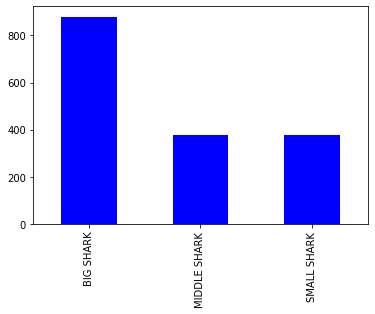

In [20]:
size_attacks = shark_sizes['Shark Sizes'].value_counts().head(3)
size_attacks.plot.bar(color= 'blue')
